In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta, date
import copy
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

В данном исследовании я буду использовать датасет о показателях суицидов в период с 1985 по 2016. Данные были взяты с сайта https://kaggle.com.

**ПЕРВИЧНЫЙ АНАЛИЗ**

In [2]:
df = pd.read_csv('master.csv')

Набор данных взят и скомпонован из четырех других, связанных по времени и месту, и был создан для поиска сигналов, связанных с повышенным уровнем самоубийств среди различных когорт во всем мире, по всему социально-экономическому спектру.

Датасет содержит данные о прецедентах для разных возрастных категорий. Поля таблицы:
 - страна
 - год
 - пол
 - возрастная категория
 - количество суицидов на категорию
 - численность населения в категории
 - уровень самоубийств (число прецедентов на 100к жителей) на категорию
 - ключ страна-год
 - ИЧР (индекс человеческого развития) - показатель, описывающий уровень жизни, образованности и долголетия
 - ВВП в год
 - ВВП на душу населения
 - поколение (определяется на основе среднего по возрастным группам)
 
Остальная информация о данных представлена ниже.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
country-year          27820 non-null object
HDI for year          8364 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [4]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [5]:
df.head(1)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X


**Предобработка данных**

Буду исследовать показатели самоубийств в бывших республиках СССР и нынешних странах СНГ. В датасете представлены 12 представителей (не хватает только Молдавии, Таджикистана и Литвы). Но так как представители стран Балтики и Центральной Азии в достатке в списке, тремя республиками пренебрегу. Абстрагируюсь от полового, возрастного категориального признака и удалю из датасета колонки $\texttt{sex}$, $\texttt{year}$ и $\texttt{generation}$, ведь интересен общий демографический уровень в государстве. Также удалю ненужный идентификатор $\texttt{country-year}$ и на 70% пустой признак $\texttt{HDI for year}$. $\texttt{suicides/100k pop}$ и $\texttt{gdp_per_capita}$ теряют смысл после этих манипуляций с данными, поэтому также извлеку их из таблицы. Далее - объединим данные по стране для каждого года, в случае отсуствия данных по какому-то году из оставшихся в таблице добавим новую строчку со средними значениями для страны.

In [6]:
df = df.drop(['sex', 'age', 'generation', 'country-year', 'HDI for year', 'suicides/100k pop', 'gdp_per_capita ($)'], axis=1)

In [7]:
countries = [
    'Russian Federation',
    'Armenia',
    'Azerbaijan',
    'Belarus',
    'Estonia',
    'Georgia',
    'Kazakhstan',
    'Kyrgyzstan',
    'Latvia',
    'Turkmenistan',
    'Ukraine',
    'Uzbekistan'
]

In [8]:
box = df[[df['country'][i] in countries for i in range(df.shape[0])]]
box.shape

(3406, 5)

In [9]:
print('year number of countries')
tmp = [print(year, box[box.year==year].country.unique().size) for year in range(1985, 2017)]

year number of countries
1985 0
1986 0
1987 2
1988 2
1989 3
1990 10
1991 10
1992 10
1993 9
1994 10
1995 12
1996 12
1997 12
1998 12
1999 12
2000 12
2001 12
2002 11
2003 11
2004 10
2005 9
2006 9
2007 11
2008 9
2009 11
2010 11
2011 11
2012 10
2013 10
2014 11
2015 9
2016 1


Видно, что можно выбросить из таблицы данные о 1985-1988 годах и 2016 году.

Схлопнем оставшиеся данные по годам, убрав границы между государствами на какое-то время, и восстановим признаки $\texttt{suicides/100k}$ и $\texttt{gdp_per_capita}$.

In [10]:
box = box[box.year > 1988][box.year != 2016]
box[' gdp_for_year ($) '] = [np.int64(box[' gdp_for_year ($) '][i].replace(',', '')) for i in box.index]

C:\Users\miracle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [11]:
data = box.groupby(by=['year'])['suicides_no', 'population'].sum()
data = data.rename(columns={'suicides_no' : 'suicides'})

ficha = box.groupby(by=['country', 'year'])[' gdp_for_year ($) '].mean()
ficha = ficha.reset_index(level='country')
ficha = ficha.groupby(by='year')[' gdp_for_year ($) '].sum()
data['gdp_for_year'] = ficha

data['gdp_per_capita'] = data['gdp_for_year'] / data['population']
data['suicides/100k'] = data['suicides'] / data['population'] * 100000
data = data.reset_index(level='year')

print(data.shape)
data.head(5)

(27, 6)


,year,suicides,population,gdp_for_year,gdp_per_capita,suicides/100k
0,1989,49061,186204500,592216323276,3180.461929,26.347913
1,1990,57637,246662200,684946415921,2776.860078,23.366774
2,1991,57829,248759350,674983722400,2713.400410,23.246965
3,1992,65906,251344200,604589425398,2405.424217,26.221413
4,1993,77602,246836600,563903168804,2284.520078,31.438612


**Визуальный анализ данных**

Построим графики зависимостей уровня самоубийств от ВВП в год, уровня самоубийств от года и количества самоубийств от года.

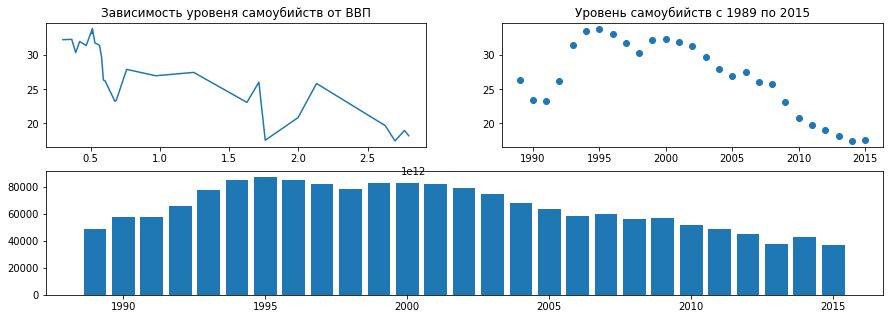

In [12]:
fig = plt.figure(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)

ax1 = plt.subplot(212)
ax2 = plt.subplot(222)

ax1.bar(data.year, data.suicides)

ax2.set_title("Уровень самоубийств с 1989 по 2015")
ax2.scatter(data.year,
            data['suicides/100k'])

ax3 = plt.subplot(221)
ax3.set_title('Зависимость уровеня самоубийств от ВВП')
ax3.plot(np.sort(data['gdp_for_year']),
                data['suicides/100k'][np.argsort(np.array(data['gdp_for_year']))])

Количество суицидов резко выросло к середине 90-х, когда внутренние ресурсы стран СНГ израсходовались после распада СССР. Достаточно вспомнить бесконечные очередии за хлебом, чтобы подтвердить правильность статистики. 1994 год был настоящей катастрофой для стран СНГ http://www.demoscope.ru/weekly/2004/0161/analit01.php. Тренд в зависимости уровня самоубийств от ВВП и в зависимости количества самоубийств легко выделяется: он явно низходящий. То есть лучше экономическая ситуация в стране, тем, очевидно, лучше живется гражданам.

**Исследование**

Построим STL-декомпозицию уровня самоубийств и ВВП на душу населения и на основании результатов выдвинем гипотезу.

In [13]:
years = data.year.astype('str')
years = pd.DatetimeIndex(years)
suicides = pd.Series(np.array(data['suicides/100k']),
                     index=years)
dgp_capita = pd.Series(np.array(data['gdp_per_capita']),
                     index=years)

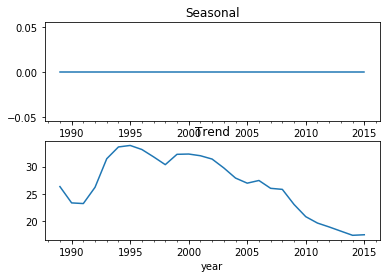

In [14]:
components = sm.tsa.seasonal_decompose(suicides)

ax1 = plt.subplot(211)
components.seasonal.plot(title='Seasonal')

ax1 = plt.subplot(212)
components.trend.plot(title='Trend')

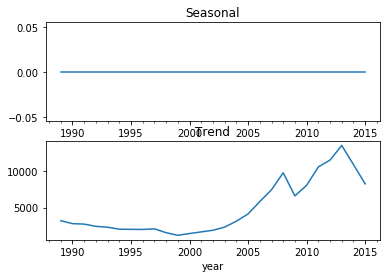

In [15]:
components = sm.tsa.seasonal_decompose(dgp_capita)

ax1 = plt.subplot(211)
components.seasonal.plot(title='Seasonal')

ax1 = plt.subplot(212)
components.trend.plot(title='Trend')

Удалось выделить тренд у обоих показателей: низходящий для числа самоубийств и восходящий для показателя ВВП на душу населения, сезонность же выявить невозможно. Заметен рост благополучия в странах СНГ, так как число суицидов уменьшается, а ВВП на душу населения увеличивается. Это же подтверждается статистикой https://pikabu.ru/story/kak_menyalsya_uroven_zhizni_v_rossii_za_poslednie_130_let_5695251.

Легко видеть обратную зависимость, как уже косвенно подмечалось выше.

Сформулирую гипотезу: "Число смертей обратно пропорционально ВВП, приходящееся на душу населения".

Заменю данные о показателе ВВП обратной величиной и буду строить прямую зависимость последних и данных о самоубийствах.

Для проверки гипотезу обучу линейную модель и проведу оценку с помощью t-критерий Стьюдента.

In [16]:
info = pd.DataFrame()
info['capita'] = 1 / data['gdp_per_capita']
info['suicides'] = data['suicides']

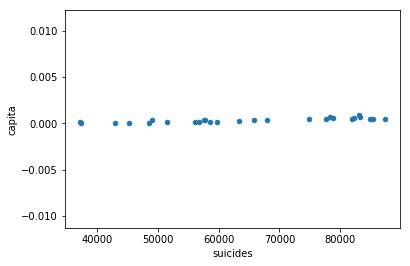

In [17]:
info.plot.scatter('suicides', 'capita')

Нетрудно увидеть линейную зависимость.

In [18]:
model = smf.ols('capita~suicides',data=info)
fitted = model.fit()

In [19]:
fitted.params

Intercept   -4.310533e-04
suicides     1.199945e-08
dtype: float64

In [20]:
info['predicted'] = fitted.params[0] + fitted.params[1] * info['suicides']

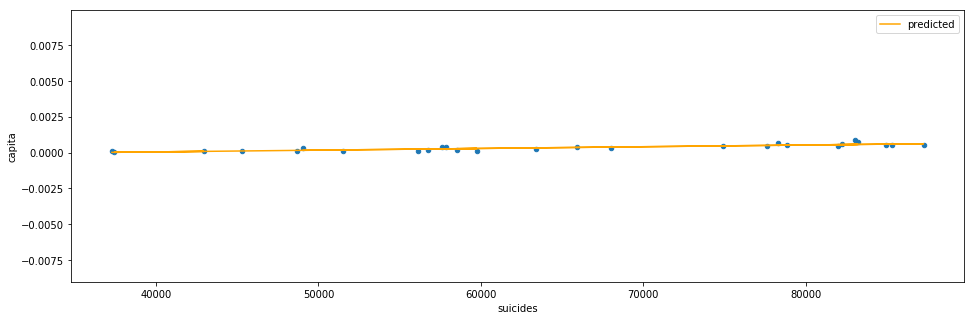

In [21]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

info.plot.scatter('suicides','capita',ax = ax1)
info.plot.line('suicides','predicted',ax = ax1,color = 'orange')

In [22]:
fitted.rsquared

0.75146604205428

In [23]:
fitted.tvalues

Intercept   -4.674302
suicides     8.694244
dtype: float64

In [24]:
fitted.pvalues

Intercept    8.667040e-05
suicides     4.986751e-09
dtype: float64

Исходя из значения p-value, гипотезу отвергнуть нельзя, то есть показатели действительно имеют обратную зависимость.

**Предсказание временного ряда**

Попробуем спрогнозировать поведение ряда.

Проверим стационарность ряда на статическом тесте. Сдвигов производить не нужно, потому что данные не обладают свойством сезонности.

In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

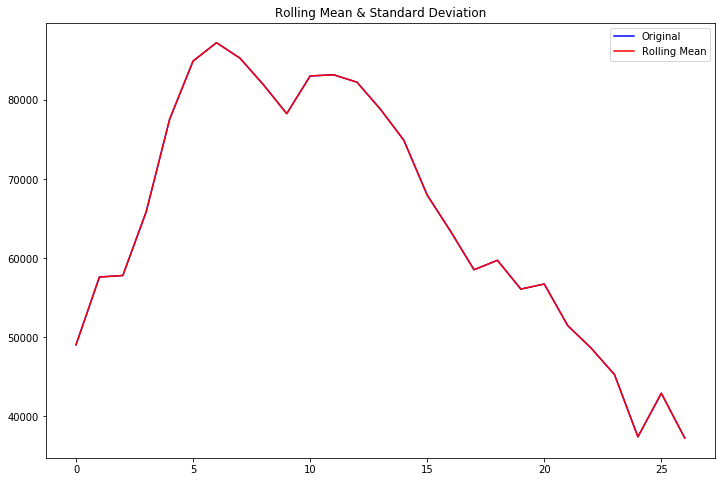

Results of Dickey-Fuller Test:
p-value = 0.2399. The series is likely stationary.
Test Statistic                 -2.111506
p-value                         0.239913
#Lags Used                      9.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


In [26]:
test_stationarity(data['suicides'], window = 1, cutoff = 0.5)    

Ряд стационарен, поэтому построение временного ряда должно увенчаться успехом.

Для предсказания я буду использовать метод линейного тренда Холта-Уинтерса.

In [27]:
train = data.iloc[:22]
test = data.iloc[22:]

In [28]:
best_holt_linear_rmse = None

for sl in np.arange(0, 1, 0.1):
    for ss in np.arange(0, 1, 0.1):
        fit = Holt(train.suicides.values).fit(smoothing_level=sl,
                                              smoothing_slope=ss)
        y_pred = fit.forecast(len(test))
        rmse = mean_squared_error(test.suicides, y_pred)
        
        if best_holt_linear_rmse is None or rmse < best_holt_linear_rmse:
            best_holt_linear_fit = fit
            best_holt_linear_rmse = rmse
            best_ss_hl = ss
            best_sl_hl = sl

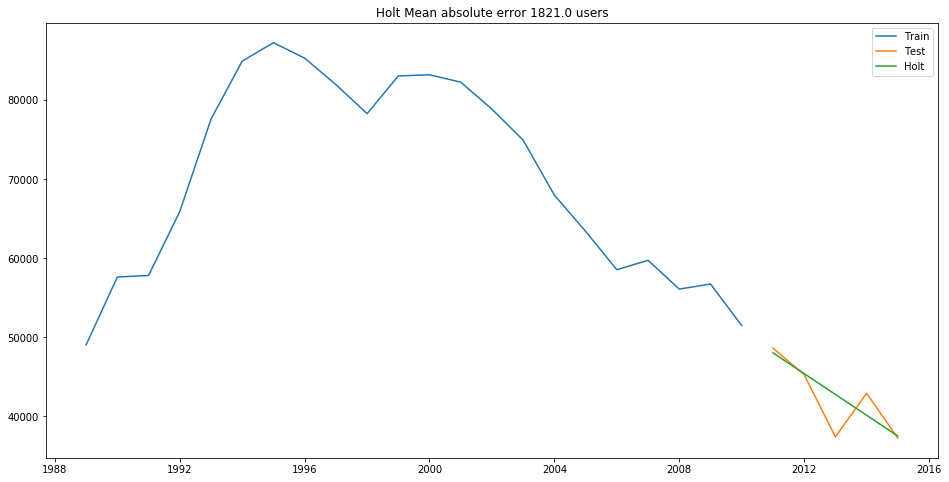

In [29]:
y_pred = pd.DataFrame()
y_pred['holt'] = best_holt_linear_fit.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(years[:22], train.suicides, label='Train')
plt.plot(years[22:], test.suicides, label='Test')
plt.plot(years[22:], y_pred['holt'], label='Holt')
plt.title("Holt Mean absolute error {} users"\
            .format(round(mean_absolute_error(y_pred['holt'],
                                              test.suicides.values))))
plt.legend(loc='best')
plt.show()

Модель неплохо справилась с предсказанием, практически точно попав в границы значений.

Сделаем предсказание на 4 года вперед.

In [30]:
holt_linear_fit = Holt(data.suicides.values).fit(smoothing_level=best_sl_hl, smoothing_slope=best_ss_hl)

In [31]:
ind = pd.DatetimeIndex(['2016', '2017', '2018', '2019'])

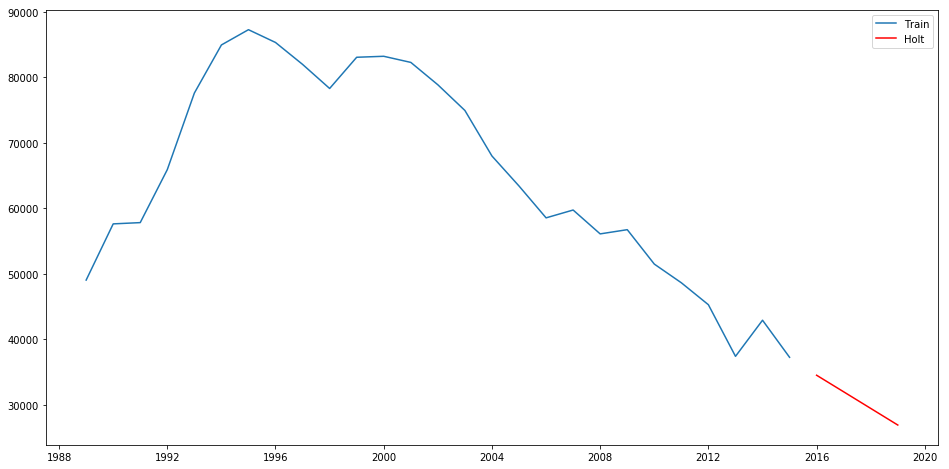

In [32]:
y_pred = pd.DataFrame()
y_pred['holt'] = holt_linear_fit.forecast(4)
plt.figure(figsize=(16,8))
plt.plot(years, data.suicides, label='Train')
plt.plot(ind, y_pred['holt'], label='Holt', color='r')
plt.legend(loc='best')
plt.show()

Как видим, предсказание неплохо построилось. Наблюдается предсказываемый понижающий тренд, что говорит о будущем уменьшении числа самоубийств в странах СНГ.

**Выводы**

Я провел анадиз данных о количестве самоубийств, произошедших в странах СНГ в период с 1989 по 2015 года.
Полученные результаты:
 1. Обнаружена тенденция роста ВВП в странах СНГ и уменьшение числа самоубийств, что говорит о том, что государствам удалось "встать на ноги" после неожиданно сваливашегося на них суверенитета в 1991 году. И сторонние источники подтверждают это (https://visasam.ru/emigration/pereezdsng/uroven-zhizni-sng.html).
 2. Обнаружена обратная пропорциональность между показателем ВВП на душу населения и числом самоубийств.
 3. Тенденция к уменьшению числа самоубийств предсказана временным рядом, что говорит о росте благополучия на постсоветском пространстве.